In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "benchmark_summary"

file_suffix = time.strftime('%b%d-%H%M')
data_dir = Path(f"../data/{proj_name}")
save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

### Metrics profiling

In [4]:
method_mapping = {
    "unintegrated": "Unintegrated",
    "scanorama": "Scanorama",
    "liger": "Liger",
    "harmony": "Harmony",
    "scvi": "scVI",
    "seurat_cca": "Seurat(cca)",
    "seurat_rpca": "Seurat(rPCA)",
    "contrastive": "Contrastive",
    "concord_hcl": "CONCORD(hcl)",
    "concord_knn": "CONCORD(kNN)",
}


metrics_paths = {
    "Lung atlas": data_dir / "summary_metrics_integration/benchmark_lungv1_5k_Aug09-1551.pkl",
    "GTEX v9": data_dir / "summary_metrics_integration/benchmark_cross_tissue_Eraslan_Jul24-1358.pkl",
    "HypoMap": data_dir / "summary_metrics_integration/benchmark_HypoMap_Steuernagel_refined_Jul24-1358.pkl",
    "Immune cell atlas": data_dir / "summary_metrics_integration/benchmark_immune_DominguezConde_Jul24-1358.pkl",
    "Mouse pancreatic islet": data_dir / "summary_metrics_integration/benchmark_pancreatic_islet_Hrovatin_Jul24-1358.pkl",
    "Tabula Sapiens": data_dir / "summary_metrics_integration/benchmark_TabulaSapiens_n=300_Jul24-1358.pkl",
    "C.elegans cell type": data_dir / "summary_metrics_integration/benchmark_cel_packerN2_cell_type_Jul31-1241.pkl",
    "C.elegans lineage": data_dir / "summary_metrics_integration/benchmark_cel_packerN2_lineage_complete_Jul31-1241.pkl",
    "PBMC scATAC" : data_dir / "summary_metrics_integration/benchmark_pbmc_atac_celltype_Aug07-1244.pkl"
}


In [9]:
import pandas as pd
import pickle as pkl
from pathlib import Path

def update_aggregate_scores(bm):
    df = bm["combined"]

    # Recompute scores
    df.loc[:, ("Aggregate score", "Batch correction")] = df["Batch correction"].mean(axis=1)
    df.loc[:, ("Aggregate score", "Bio conservation")] = df["Bio conservation"].mean(axis=1)

    # Average the two sub-aggregate scores directly
    total_score = df.loc[:, ("Aggregate score", "Batch correction")].astype(float).add(
        df.loc[:, ("Aggregate score", "Bio conservation")].astype(float)
    ).div(2)

    df.loc[:, ("Aggregate score", "Total")] = total_score

    # Drop the old "Aggregate score", "Average" column
    if ("Aggregate score", "Average") in df.columns:
        df.drop(columns=[("Aggregate score", "Average")], inplace=True) 

    df.index.name = "Method"

    return df


In [10]:
metrics_dict = {}
for metric_name, metric_path in metrics_paths.items():
    with open(metric_path, "rb") as f:
        bm = pkl.load(f)
        metrics_dict[metric_name] = update_aggregate_scores(bm)

metrics_dict


{'Lung atlas':                Batch correction                                     \
              Graph connectivity     iLISI      KBET PCR comparison   
 Method                                                               
 concord_hcl            0.915438   0.11641  0.368998       0.875021   
 scvi                   0.898235  0.118117   0.34122       0.926934   
 concord_knn            0.892299  0.109481  0.411111       0.938087   
 seurat_rpca            0.745252  0.132886  0.457314       0.848078   
 harmony                0.799156   0.09292  0.393433       0.559395   
 seurat_cca              0.54497  0.172427  0.431475       0.902208   
 contrastive            0.782449  0.014985  0.262344       0.556528   
 liger                  0.752922  0.128583  0.374063       0.838841   
 scanorama              0.759803   0.04852  0.274837       0.308852   
 unintegrated           0.734657  0.000996  0.195944       0.189265   
 
                               Bio conservation              

### Save the results to Supp table

In [11]:
# Combine into a single sheet 
import pandas as pd
import xlsxwriter   # imported implicitly by the engine
from pathlib import Path

out_file = save_dir / f"realworld_benchmark_results_combined_{file_suffix}.xlsx"

with pd.ExcelWriter(out_file, engine="xlsxwriter") as writer:
    workbook  = writer.book
    # Create (or grab) a single sheet that everything goes into
    worksheet = workbook.add_worksheet("AllResults")
    writer.sheets["AllResults"] = worksheet

    # Optional – nice formatting helpers
    heading_fmt = workbook.add_format({"bold": True, "align": "left"})
    num_fmt     = workbook.add_format({"num_format": "0.000"})   # example

    startrow = 0
    for name, df in metrics_dict.items():
        # -- 1. heading ----------------------------------------------------
        worksheet.write(startrow, 0, name, heading_fmt)

        # -- 2. the table --------------------------------------------------
        # If you prefer flat column names, uncomment the three lines below
        # flat_cols = [" | ".join(tup).strip()
        #              if isinstance(tup, tuple) else tup
        #              for tup in df.columns.to_flat_index()]
        # df = df.copy(); df.columns = flat_cols

        df.to_excel(
            writer,
            sheet_name="AllResults",
            startrow=startrow + 1,   # leave the heading on its own line
            startcol=0,
            index=True               # keep row index; drop if you don’t need it
        )

        # (Optional) apply a numeric format to the body of the table
        body_rows  = df.shape[0]
        header_rows = df.columns.nlevels        # multi‑index depth
        first_body = startrow + 1 + header_rows
        last_body  = first_body + body_rows - 1
        last_col   = df.shape[1]                # +1 if you wrote the index=False

        worksheet.set_column(0, last_col, 12, num_fmt)   # width 12, numeric fmt

        # -- 3. bump the cursor -------------------------------------------
        startrow += header_rows + body_rows + 3   # +2 ⇒ one completely blank line


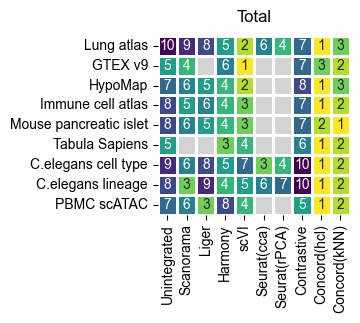

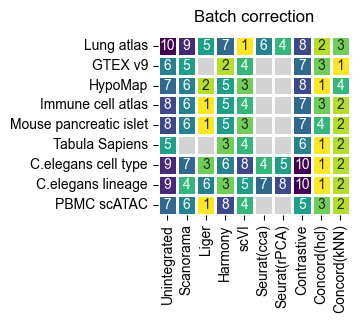

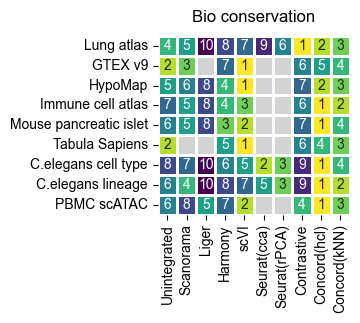

In [252]:
from benchmark_utils import plot_ranked_scores
score_keys = [("Aggregate score", "Total"), ("Aggregate score", "Batch correction"), ("Aggregate score", "Bio conservation")]

for score_key in score_keys:
    score_dict = {key: metrics_dict[key][score_key] for key in metrics_dict}
    with plt.rc_context(rc=custom_rc):
        plot_ranked_scores(score_dict,
                        figsize = (len(method_mapping) * 0.37, len(score_dict) * 0.37),
                        custom_rc=custom_rc,
                        method_mapping= method_mapping,
                    title=score_key[1],
                    save_dir=save_dir,
                    file_name=f"metrics_ranked_{score_key[1]}_{file_suffix}",
                        save_format="svg"
                    )

### Resource profiling

In [11]:
import re
methods = method_mapping.keys()
# remove "unintegrated"
methods = [m for m in methods if m != "unintegrated"]
dataframes = {}
resource_dir = data_dir/"summary_resource_profiling"
for file in resource_dir.glob("*.tsv"):
    if file.name.startswith("._") or file.stat().st_size < 10:
        continue  # Skip hidden/empty files

    # Extract name between 'benchmark_' and '_summary'
    match = re.search(r"benchmark_(.*)_summary", file.stem)
    if match:
        df_name = match.group(1)
    else:
        df_name = file.stem  # fallback

    try:
        dataframes[df_name] = pd.read_csv(file, sep="\t", encoding="utf-8")
    except UnicodeDecodeError:
        try:
            dataframes[df_name] = pd.read_csv(file, sep="\t", encoding="ISO-8859-1")
            print(f"Loaded with fallback encoding: {file.name}")
        except Exception as e:
            print(f"❌ Failed to load {file.name}: {e}")

In [12]:
dataset_display_names = {
        "cross_tissue_Eraslan": "GTEX v9",
        "HypoMap_Steuernagel": "HypoMap",
        "pancreatic_islet_Hrovatin": "Mouse pancreatic islet",
        "immune_DominguezConde": "Immune cell atlas",
        "TabulaSapiens_n=300": "Tabula Sapiens",
        "lungv1_5k": "Lung atlas",
        "cel_packerN2": "C.elegans atlas",
        "CBCEcombineN2": "Cel/Cbr atlas",
        "Huycke_intestine": "Intestine atlas",
        "pbmc_atac": "PBMC scATAC",
        "Janesick_alltech": "Breast cancer TME"
}

In [13]:
datasets = dataset_display_names.keys()
ram_df = pd.DataFrame(index=methods, columns=datasets)
vram_df = pd.DataFrame(index=methods, columns=datasets)
time_df = pd.DataFrame(index=methods, columns=datasets)

for dataset in datasets:
    df = dataframes[dataset]
    df = df.set_index("method")
    ram_df[dataset] = df["ram_MB"]
    vram_df[dataset] = df["vram_MB"]
    time_df[dataset] = df["time_sec"]
    

# save the DataFrame with file suffix in the same directory
ram_df.to_csv(data_dir / f"summary_ram_usage_{file_suffix}.csv")
vram_df.to_csv(data_dir / f"summary_vram_usage_{file_suffix}.csv")
time_df.to_csv(data_dir / f"summary_time_usage_{file_suffix}.csv")

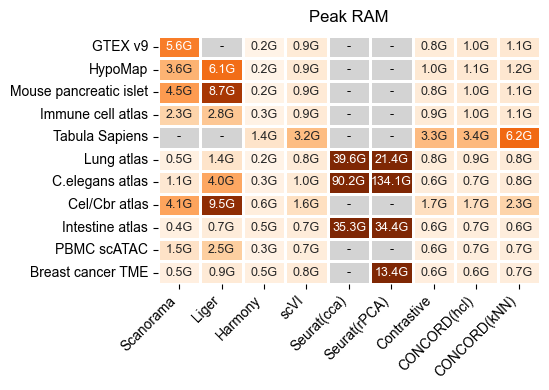

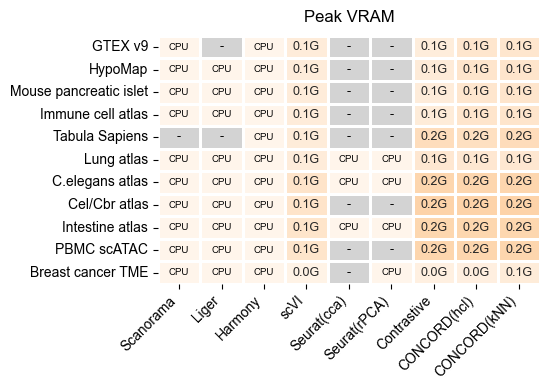

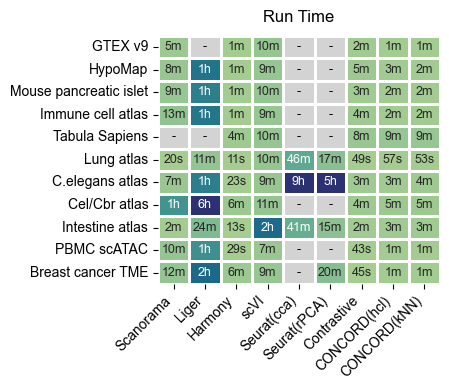

In [15]:
from benchmark_utils import plot_resource_usage_heatmap
with plt.rc_context(rc=custom_rc):
    plot_resource_usage_heatmap(ram_df, resource_type="RAM", title="Peak RAM",
                                method_mapping=method_mapping,
                                dataset_display_map=dataset_display_names,
                                figsize=(5.6, 4), 
                                vmax_val=1024*10,
                                cmap = 'Oranges',
                                save_dir=save_dir, file_name=f"summary_ram_usage_heatmap_{file_suffix}",
                                save_format="svg")
    plot_resource_usage_heatmap(vram_df, resource_type="VRAM", title="Peak VRAM",
                                method_mapping=method_mapping,
                                dataset_display_map=dataset_display_names,
                                vmax_val=1024,
                                figsize=(5.6, 4), 
                                cmap = 'Oranges',
                                save_dir=save_dir, file_name=f"summary_vram_usage_heatmap_{file_suffix}",
                                save_format="svg")
    plot_resource_usage_heatmap(time_df, resource_type="Time", title="Run Time",
                                method_mapping=method_mapping,
                                dataset_display_map=dataset_display_names, 
                                cmap='crest',
                                vmax_val=3600 * 3,
                                figsize=(4.6, 4),
                                save_dir=save_dir, file_name=f"summary_time_usage_heatmap_{file_suffix}",
                                save_format="svg")